In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch
import os
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [3]:
# Sets the base directory for the dataset
base_dir = '/content/drive/My Drive/datasetX'

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Converts images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisation
])

# Datasets
train_dataset = datasets.ImageFolder(os.path.join(base_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(base_dir, 'val'), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(base_dir, 'test'), transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [4]:
class SpatialTransformerNetwork(nn.Module):
    def __init__(self):
        super(SpatialTransformerNetwork, self).__init__()

        # Spatial transformer localisation network
        self.localization = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialises the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def forward(self, x):
        xs = self.localization(x)

        # Dynamically calculates the correct size for the first linear layer in fc_loc
        if self.fc_loc[0].in_features == 1:  # Checks if it's the placeholder value
            N, C, H, W = xs.size()
            correct_size = C * H * W
            self.fc_loc[0] = nn.Linear(correct_size, 32).to(xs.device)

        xs = xs.view(-1, self.fc_loc[0].in_features)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size(), align_corners=False)
        x = F.grid_sample(x, grid, align_corners=False)
        return x

class ResNetWithSTN(nn.Module):
    def __init__(self):
        super(ResNetWithSTN, self).__init__()
        self.stn = SpatialTransformerNetwork()
        self.resnet = models.resnet18(pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, 5)  # Adjusting for 5 classes

    def forward(self, x):
        x = self.stn(x)  # Transforms the input
        x = self.resnet(x)  # Passes the transformed input through ResNet
        return x

In [5]:
# Transfers to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetWithSTN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def evaluate(model, data_loader, criterion):
    model.eval()  # Sets the model to evaluation mode
    val_loss = 0.0
    true_labels = []
    predictions = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            true_labels.extend(labels.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())

    val_loss /= len(data_loader.dataset)
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='macro')
    return val_loss, accuracy, precision, recall, f1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 58.4MB/s]


In [6]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25):
    metrics = {
        'train_loss': [],
        'val_loss': [],  # Stores validation loss for each epoch
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
    }

    for epoch in range(num_epochs):
        model.train()  # Sets model to training mode
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        metrics['train_loss'].append(epoch_loss)

        # Evaluates after every epoch
        val_loss, accuracy, precision, recall, f1 = evaluate(model, val_loader, criterion)
        metrics['val_loss'].append(val_loss)  # Appends validation loss to metrics
        metrics['accuracy'].append(accuracy)
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)
        metrics['f1'].append(f1)

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Acc: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')

    return metrics


# Calls to train the model
metrics = train_model(model, criterion, optimizer, train_loader, val_loader)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/25
Train Loss: 1.5430, Val Loss: 1.4882, Acc: 0.3484, Precision: 0.2218, Recall: 0.2623, F1: 0.2318
Epoch 2/25
Train Loss: 1.2614, Val Loss: 1.4690, Acc: 0.4194, Precision: 0.5350, Recall: 0.4008, F1: 0.4185


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/25
Train Loss: 1.1968, Val Loss: 1.2711, Acc: 0.4000, Precision: 0.3191, Recall: 0.3666, F1: 0.3175
Epoch 4/25
Train Loss: 1.0692, Val Loss: 1.6363, Acc: 0.4129, Precision: 0.5657, Recall: 0.4893, F1: 0.4127


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/25
Train Loss: 1.0550, Val Loss: 2.8486, Acc: 0.2258, Precision: 0.2398, Recall: 0.3670, F1: 0.2327
Epoch 6/25
Train Loss: 0.9604, Val Loss: 1.4654, Acc: 0.3677, Precision: 0.3979, Recall: 0.4230, F1: 0.3956


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7/25
Train Loss: 1.1318, Val Loss: 1.3967, Acc: 0.3871, Precision: 0.2505, Recall: 0.3486, F1: 0.2775
Epoch 8/25
Train Loss: 0.8635, Val Loss: 1.1849, Acc: 0.4581, Precision: 0.5374, Recall: 0.4778, F1: 0.4873
Epoch 9/25
Train Loss: 0.8498, Val Loss: 1.4926, Acc: 0.3806, Precision: 0.5098, Recall: 0.3516, F1: 0.3552
Epoch 10/25
Train Loss: 0.7836, Val Loss: 1.2308, Acc: 0.4387, Precision: 0.5608, Recall: 0.4188, F1: 0.4400
Epoch 11/25
Train Loss: 0.6341, Val Loss: 2.8194, Acc: 0.3548, Precision: 0.5534, Recall: 0.3896, F1: 0.3321
Epoch 12/25
Train Loss: 0.5709, Val Loss: 1.3736, Acc: 0.4645, Precision: 0.5615, Recall: 0.5500, F1: 0.5463
Epoch 13/25
Train Loss: 0.5184, Val Loss: 1.5804, Acc: 0.4645, Precision: 0.5214, Recall: 0.5476, F1: 0.5254
Epoch 14/25
Train Loss: 0.3867, Val Loss: 1.9410, Acc: 0.4387, Precision: 0.5229, Recall: 0.5093, F1: 0.5108
Epoch 15/25
Train Loss: 0.3383, Val Loss: 2.5548, Acc: 0.4258, Precision: 0.5635, Recall: 0.4712, F1: 0.4634
Epoch 16/25
Train Loss

In [9]:
# Evaluates on the test set
test_val_loss, test_accuracy, test_precision, test_recall, test_f1 = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_val_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}')


Test Loss: 3.2953, Test Accuracy: 0.4192, Precision: 0.4576, Recall: 0.4456, F1 Score: 0.4013


Original Labels:  [0 0 0 2 1 0 3 0 2 1 1 1 1 0 0 2 2 3 0 2 1 0 1 3 1 2 0 4 0 4 3 4]
Predicted Labels: [0 2 2 2 2 0 3 2 2 2 2 2 2 0 0 2 2 3 2 2 0 2 2 2 2 2 0 3 0 3 2 3]


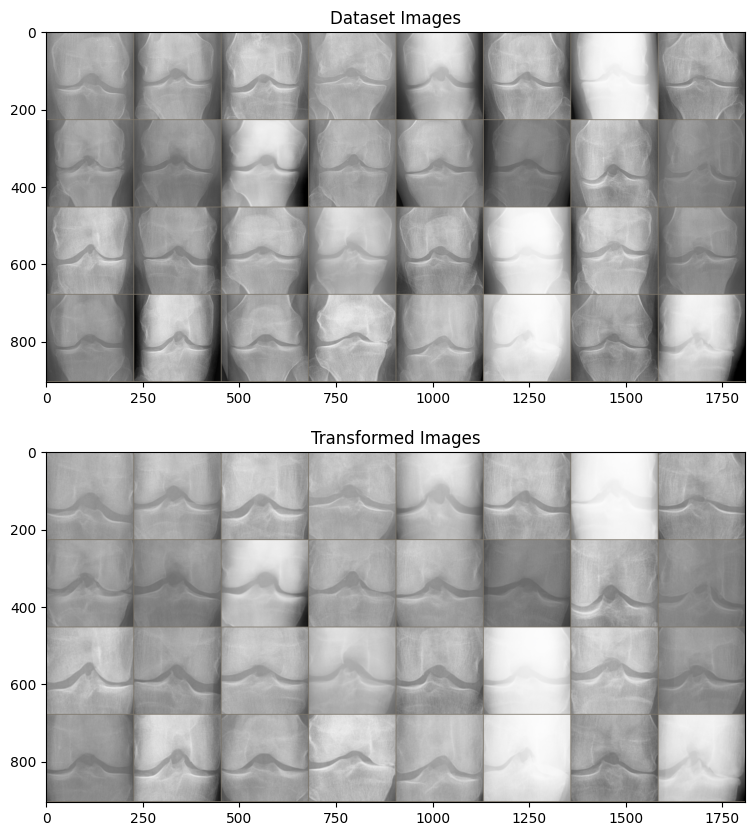

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

def visualize_stn(model, test_loader):
    with torch.no_grad():
        # Gets a batch of test data
        data, labels = next(iter(test_loader))
        data = data.to(device)

        # Transforms the input data through the STN and ResNet
        transformed_data = model.stn(data)
        output = model(data)  # Forward pass through the whole model for prediction
        _, preds = torch.max(output, 1)

        input_tensor = data.cpu()
        transformed_input_tensor = transformed_data.cpu()

        in_grid = convert_image_np(torchvision.utils.make_grid(input_tensor))
        out_grid = convert_image_np(torchvision.utils.make_grid(transformed_input_tensor))

        # Plots the results side-by-side
        f, axarr = plt.subplots(2, 1, figsize=(20, 10))
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')
        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

        # Prints original and predicted labels
        print('Original Labels: ', labels.numpy())
        print('Predicted Labels:', preds.cpu().numpy())

# Example usage
visualize_stn(model, test_loader)

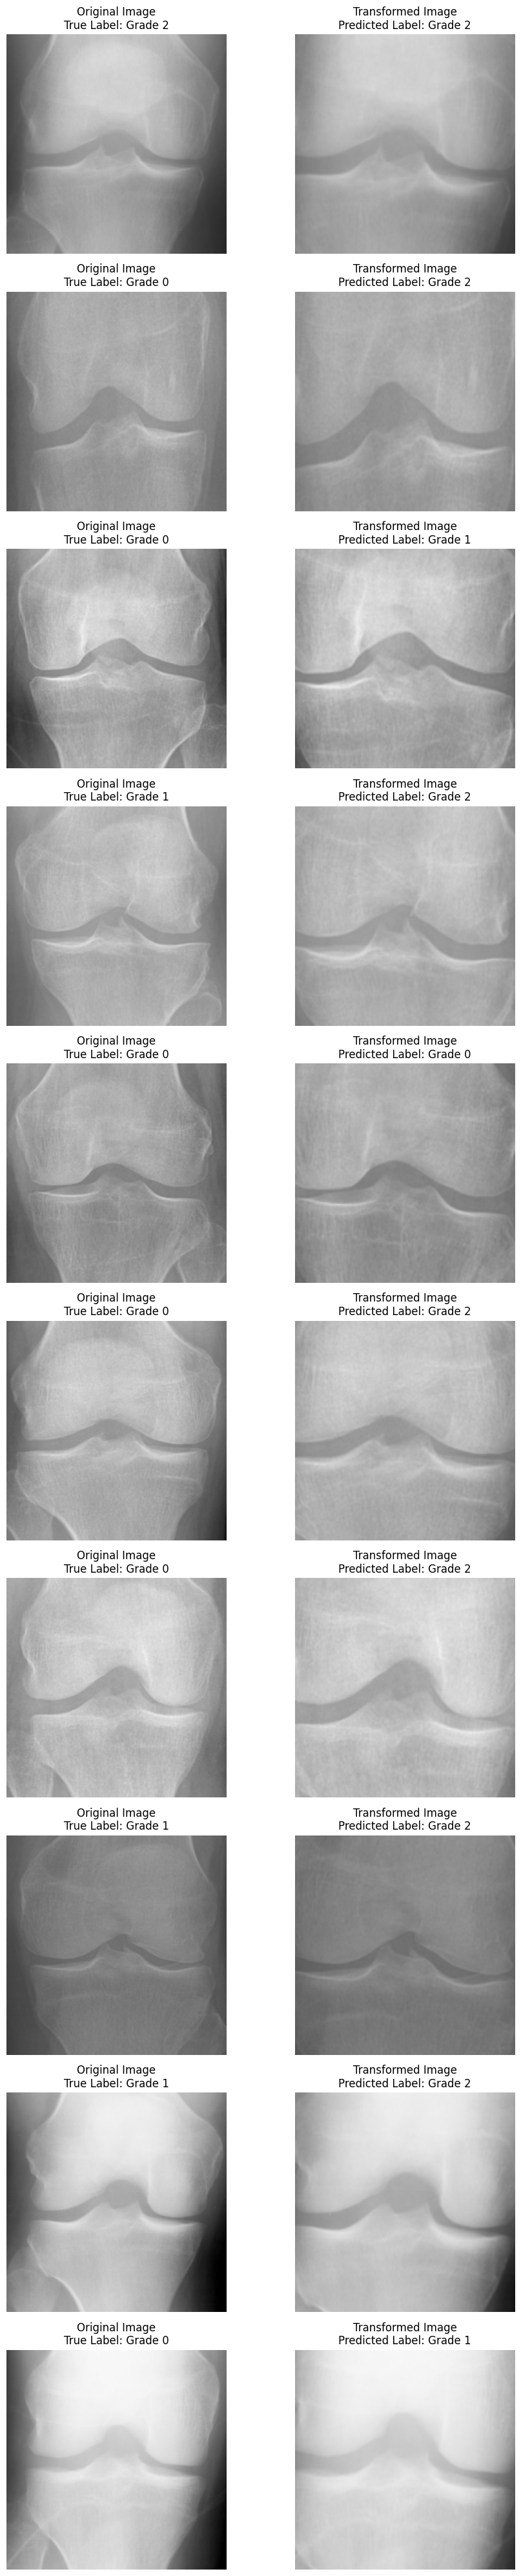

In [11]:
def visualize_comparison(model, test_loader, class_names, num_images=10):
    with torch.no_grad():
        # Gets a batch of test data
        data, true_labels = next(iter(test_loader))
        data = data.to(device)

        # Transforms the input data through the STN and ResNet
        transformed_data = model.stn(data)
        output = model(data)  # Forward pass through the whole model for prediction
        _, predicted_labels = torch.max(output, 1)

        # Moves data back to CPU for visualization
        data = data.cpu().numpy()
        transformed_data = transformed_data.cpu().numpy()
        true_labels = true_labels.cpu().numpy()
        predicted_labels = predicted_labels.cpu().numpy()

        # Initialises a plot
        fig, axes = plt.subplots(num_images, 2, figsize=(10, 4 * num_images))

        for i in range(num_images):
            # Gets the original image, true label, transformed image, and predicted label
            original_img = convert_image_np(torch.tensor(data[i]))
            true_label = class_names[true_labels[i]]
            transformed_img = convert_image_np(torch.tensor(transformed_data[i]))
            predicted_label = class_names[predicted_labels[i]]

            # Displays original image with true label
            ax = axes[i, 0]
            ax.imshow(original_img, cmap='gray')
            ax.axis('off')
            ax.set_title(f'Original Image\nTrue Label: {true_label}')

            # Display transformed image with predicted label
            ax = axes[i, 1]
            ax.imshow(transformed_img, cmap='gray')
            ax.axis('off')
            ax.set_title(f'Transformed Image\nPredicted Label: {predicted_label}')

        plt.tight_layout()
        plt.show()

# Defines the class names (assuming you have 5 classes)
class_names = ['Grade 0', 'Grade 1', 'Grade 2', 'Grade 3', 'Grade 4']

# Calls the visualization function
visualize_comparison(model, test_loader, class_names)

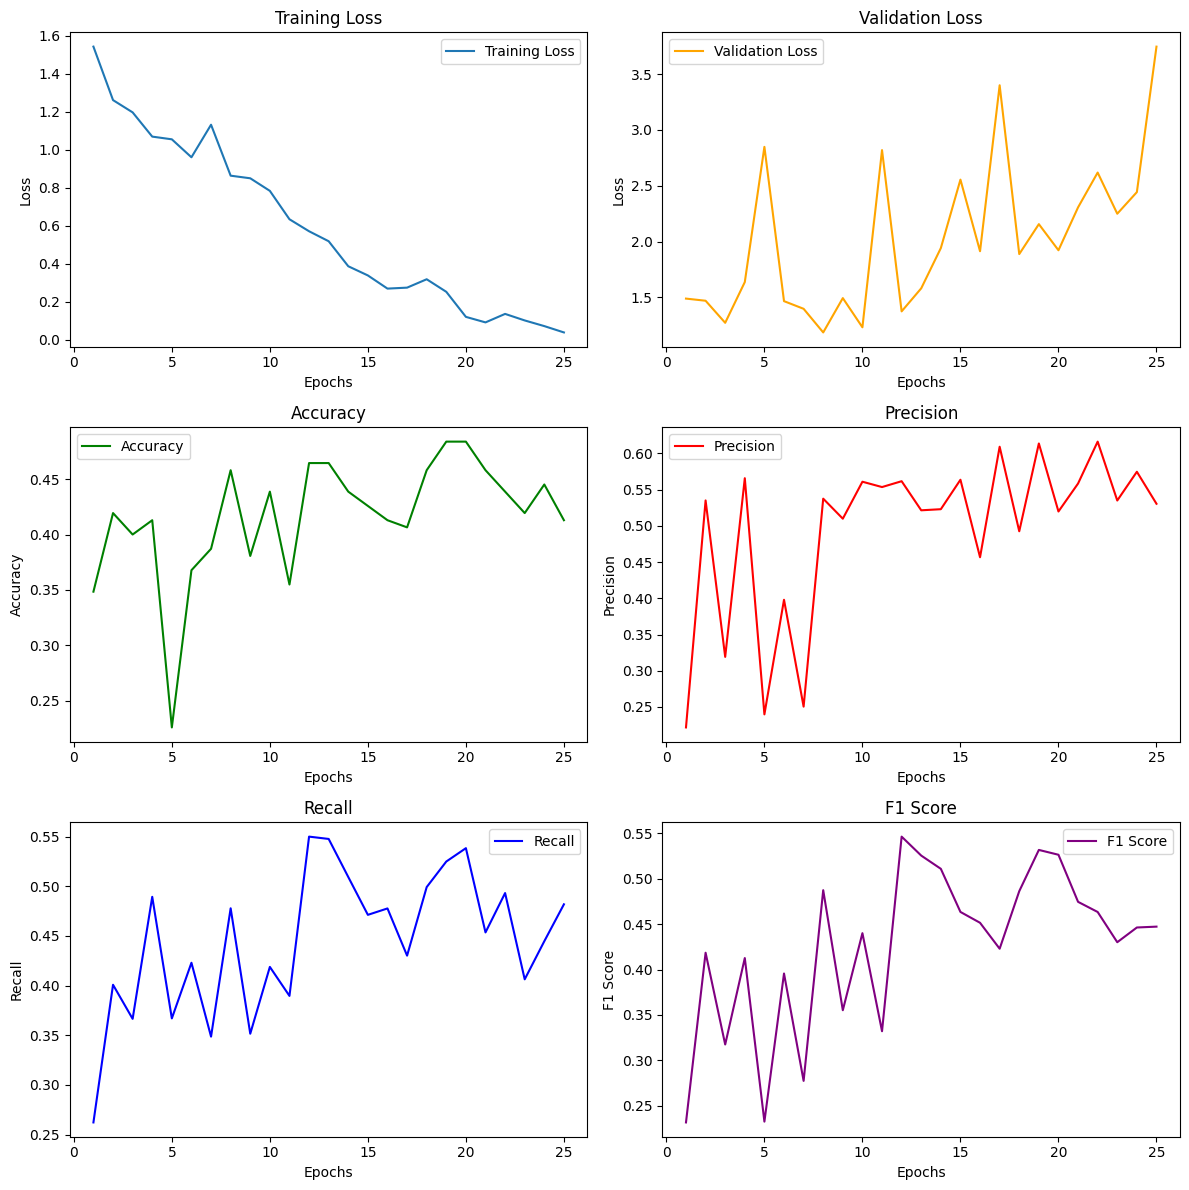

In [13]:
def plot_metrics(metrics):
    epochs = range(1, len(metrics['train_loss']) + 1)

    plt.figure(figsize=(12, 12))  # Adjusts the size to fit all subplots comfortably

    plt.subplot(3, 2, 1)
    plt.plot(epochs, metrics['train_loss'], label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(3, 2, 2)
    plt.plot(epochs, metrics['val_loss'], label='Validation Loss', color='orange')
    plt.title('Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(3, 2, 3)
    plt.plot(epochs, metrics['accuracy'], label='Accuracy', color='g')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(3, 2, 4)
    plt.plot(epochs, metrics['precision'], label='Precision', color='r')
    plt.title('Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    plt.subplot(3, 2, 5)
    plt.plot(epochs, metrics['recall'], label='Recall', color='b')
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    plt.subplot(3, 2, 6)
    plt.plot(epochs, metrics['f1'], label='F1 Score', color='purple')
    plt.title('F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()  # Adjusts layout to prevent overlap
    plt.show()

plot_metrics(metrics)

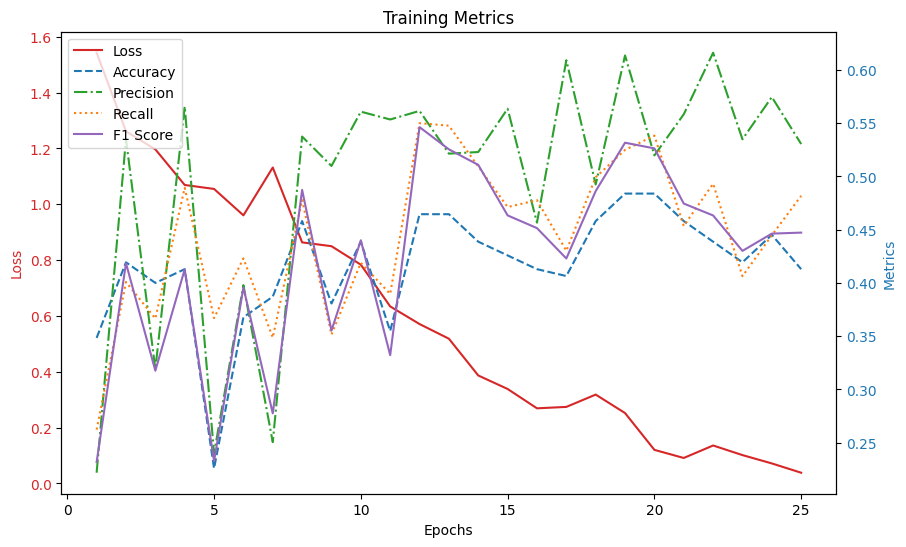

In [12]:
def plot_combined_metrics(metrics):
    epochs = range(1, len(metrics['train_loss']) + 1)

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plots training loss on the first y-axis
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(epochs, metrics['train_loss'], label='Loss', color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Creates a second y-axis for the accuracy, precision, recall, and F1
    ax2 = ax1.twinx()
    ax2.set_ylabel('Metrics', color='tab:blue')
    ax2.plot(epochs, metrics['accuracy'], label='Accuracy', color='tab:blue', linestyle='--')
    ax2.plot(epochs, metrics['precision'], label='Precision', color='tab:green', linestyle='-.')
    ax2.plot(epochs, metrics['recall'], label='Recall', color='tab:orange', linestyle=':')
    ax2.plot(epochs, metrics['f1'], label='F1 Score', color='tab:purple', linestyle='-')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # Creates a legend that includes all the lines
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')

    plt.title('Training Metrics')
    plt.show()

# Calls the plotting function
plot_combined_metrics(metrics)